In [1]:
import argparse
import logging
import numpy as np
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from evaluate import evaluate
from utils.dice_score import dice_loss
from unet.unet_model import UNet
from utils.data_loading import BFDataset

In [2]:
torch.cuda.is_available()

True

In [3]:
dir_checkpoint = Path('./checkpoints/')
data_dir = './data/'
dataset = BFDataset(data_dir)
len(dataset)

104

In [4]:
dataset[0]['image'].shape

torch.Size([6, 512, 512])

In [5]:
# Training on the dataset
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 1.0,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    # 1. Create dataset
    dataset = BFDataset(data_dir)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape} channels. Please check that ' \
                    f'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
#                        for tag, value in model.named_parameters():
#                            tag = tag.replace('/', '.')
#                            if not (torch.isinf(value) | torch.isnan(value)).any():
#                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
#                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
#                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


In [6]:
epochs = 5
batch_size = 1
learning_rate = 1e-5
val_percent = 0.2

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [7]:
model = UNet(n_channels=6, n_classes=1)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
           f'\t{model.n_channels} input channels\n'
           f'\tTransposed conv upscaling')

model.to(device=device)

train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    learning_rate = learning_rate,
    device = device,
    val_percent=val_percent
)

INFO: Using device cuda
INFO: Network:
	6 input channels
	Transposed conv upscaling
Validation round:  95%|█████████████████████████████████████████████████████████▉   | 19/20 [00:10<00:00,  8.77batch/s]
                                                                                                                       INFO: Validation Dice score: 0.5599235892295837
Validation round: 100%|█████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  9.06batch/s]
                                                                                                                       INFO: Validation Dice score: 2.219819180027116e-05
Validation round: 100%|█████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  9.57batch/s]
                                                                                                                       INFO: Validation Dice score: 0.015419669449329376
Validation round:  95%|███████████████████████████

In [10]:
def predict_img(net, img, device, out_threshold=0.5):
    net.eval()
    img = img.to(device=device)

    with torch.no_grad():
        output = net(img).cpu()
        mask = torch.sigmoid(output) > out_threshold
    return mask[0].long().squeeze().numpy()

In [15]:
def plot_img_and_mask(brightfield, fluorescence, mask, ground_truth):
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    ax1.imshow(brightfield)
    ax2.imshow(fluorescence)
    ax3.imshow(mask)
    ax4.imshow(ground_truth)
    plt.show()

INFO: Model loaded from checkpoint_epoch5


torch.Size([6, 512, 512])


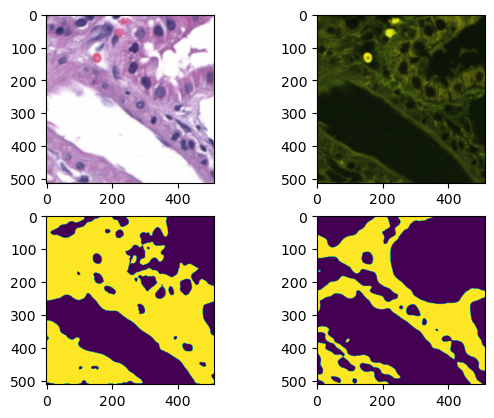

In [16]:
model = UNet(n_channels=6, n_classes=1)
model = model.to(memory_format=torch.channels_last)
model = model.to(device=device)

state_dict = torch.load('./checkpoints/checkpoint_epoch5.pth', map_location=device)
model.load_state_dict(state_dict)
logging.info(f'Model loaded from checkpoint_epoch5')
img_set = dataset.getitem(10)
print(dataset[10]['image'].size())
mask = predict_img(model, dataset[10]['image'].unsqueeze(0), device)
plot_img_and_mask(img_set['brightfield'], img_set['fluorescence'], mask, img_set['mask'])